In [2]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import librosa
import librosa.display

In [9]:
# 6.wav children playing
# 943.wav siren
# 12.wav gunshot
audio_path = './Train/943.wav'
ipd.Audio(audio_path)

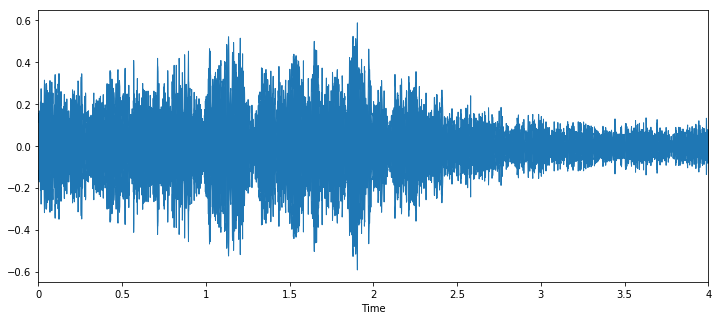

In [10]:
x, sr = librosa.load(audio_path)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

Number of crosses: 15


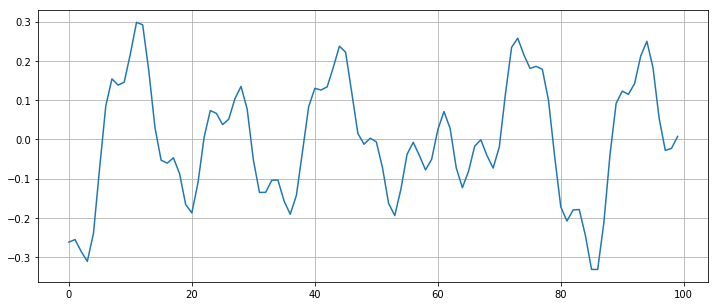

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(x[1000:1100])
plt.grid()
n_crossings = librosa.zero_crossings(x[1000:1100], pad=False)
print('Number of crosses:', sum(n_crossings))

In [12]:
centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print('Centroids Shape:', centroids.shape)
print('First 3 centroids:', centroids[:3])

Centroids Shape: (173,)
First 3 centroids: [2130.43274669 2219.1967866  2260.6601744 ]


MFFCs shape:  (20, 173)
First mffcs:  [-125.68020936 -131.4535705  -155.63851439 -166.40521245 -172.525018  ]


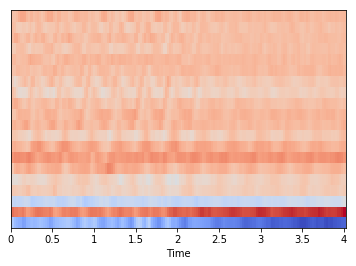

In [13]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print('MFFCs shape: ', mfccs.shape)
print('First mffcs: ', mfccs[0, :5])
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

In [14]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios():
    train_path = os.getcwd()+"/Train/"
    train_file_names = os.listdir(train_path)
    train_file_names.sort(key=lambda x: int(x.partition('.')[0]))
    
    samples = []
    for file_name in train_file_names:
        x, sr = sf.read(train_path + file_name, always_2d=True)
        x = parse_audio(x)
        samples.append(mean_mfccs(x))
        
    return np.array(samples)

def get_samples():
    df = pd.read_csv('train.csv')
    return get_audios(), df['Class'].values

In [15]:
X, Y = get_samples()
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [22]:
print('Shape: ', x_train.shape)
print('Observation: \n', x_train[0])
print('Labels:', y_train[:5])

Shape:  (4076, 20)
Observation: 
 [-2.37774385e+02  1.65117376e+02  7.11742440e+01  5.46032487e+00
 -6.95795737e+00 -1.22690372e+01 -1.43751014e+01 -1.15082835e+01
 -1.30136531e+01  1.39279678e+00 -2.12977434e+00 -2.10282993e+00
 -3.86388711e+00 -8.85878041e-01 -1.78809208e+00  2.81479660e+00
 -9.81152093e-03 -1.01558580e+00 -9.34488930e-01  3.70672884e+00]
Labels: ['dog_bark' 'engine_idling' 'air_conditioner' 'air_conditioner' 'drilling']


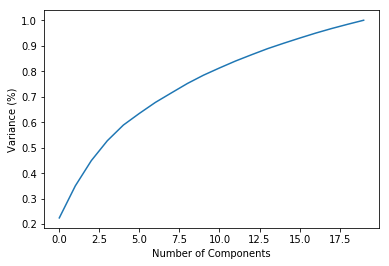

In [23]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [24]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance'], 'n_neighbors': [3, 5, 7, 9, 11, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
print('Model Score:', model.score(x_test_scaled, y_test))

y_predict = model.predict(x_test_scaled)
print('Confusion Matrix: \n', confusion_matrix(y_predict, y_test))

Model Score: 0.9190581309786607
Confusion Matrix: 
 [[157   3   2   4   2   0   0   0   1   0]
 [  0  59   0   1   1   0   0   0   0   0]
 [  0   4 136   9   1   0   2   0   2   7]
 [  0   2   0 125   1   1   4   0   1   6]
 [  0   0   2   0 134   0   0   0   0   0]
 [  0   0   2   2   2 158   0   0   1   4]
 [  0   0   0  10   1   0  54   0   0   0]
 [  0   2   0   1   1   0   0 151   0   2]
 [  0   0   0   3   0   1   0   0 140   1]
 [  0   9   7   1   1   1   0   1   1 135]]
